In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
import warnings

warnings.filterwarnings("ignore")

/home/ww6p9/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ww6p9/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
df_train = pd.read_pickle("../input/df_train.pkl")

use_cols = df_train.columns.values.tolist()
df_cat_cols = pd.read_csv("../input/cat_cols.csv", header=None)
cat_cols = df_cat_cols[0].values.tolist()
TARGET = "acsc_flag"
use_cols.remove(TARGET)

cat_cols = [col for col in cat_cols if col in use_cols]

print(df_train.shape)
df_train.head()

(5000000, 143)


,LOSD1,UNIT110,UNIT114,UNIT170,UNIT200,UNIT206,UNIT214,CHG001,CHG260,CHG480,...,CC_GRP_10,TOT_GRP,totalcc,wgtcc,sex1,urstat1,race1,age,payor2,acsc_flag
0,1,0,0,0,0,0,0,5967.00,0.0,0.0,...,0,0,0,0,0,1,2,3,3,0
1,1,0,0,0,0,0,0,2650.00,0.0,0.0,...,0,0,0,0,0,1,2,3,3,0
2,1,0,0,0,0,0,0,1077.16,0.0,0.0,...,0,0,0,0,0,0,2,3,2,0
3,21,21,0,0,0,0,0,62514.00,0.0,0.0,...,0,0,0,0,0,1,1,3,2,0
4,1,0,0,0,0,0,0,3001.25,0.0,0.0,...,0,0,0,0,0,0,1,3,2,0


In [3]:
# use_cols = ["PDIAG10"]
# cat_cols = ["PDIAG10"]

use_cols.remove("PDIAG10")
cat_cols.remove("PDIAG10")

In [4]:
cv= 3
kf = StratifiedKFold(n_splits=cv, shuffle=False, random_state=42)
oof_pred = np.zeros(df_train.shape[0])
models = {}

param = {
    "objective": "binary",
    'metric': 'auc',
    'num_leaves': 512,
    'learning_rate': 0.3,
    'n_estimators': 3000,
    'subsample': 0.7,
    "feature_fraction": 0.3,
    "lambda_l1": 8,
    "lambda_l2": 8,
    "max_depth": 12,
    'seed': 42,
    'n_jobs': -1
}
    
for fold, (train_index, valid_index) in enumerate(kf.split(df_train, y = df_train[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train.iloc[train_index][use_cols], df_train.iloc[valid_index][use_cols]
    y_train, y_valid = df_train.iloc[train_index][TARGET], df_train.iloc[valid_index][TARGET]
    
    model_lgb = lgb.LGBMRegressor(**param)
    
    model_lgb.fit(X_train, y_train,
                            eval_set=[(X_train, y_train), (X_valid, y_valid)],
                            categorical_feature=cat_cols,
                            early_stopping_rounds=100,
                            verbose=200)

    y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
    oof_pred[valid_index] = y_pred_valid
    
    models[fold] = model_lgb
    
print("-------------------------------------")
print("Overall AUC score is", roc_auc_score(df_train[TARGET], oof_pred))

Traning on folder 0 ...
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.959107	valid_1's auc: 0.935431
[400]	training's auc: 0.969006	valid_1's auc: 0.934796
Early stopping, best iteration is:
[301]	training's auc: 0.965227	valid_1's auc: 0.936763
Traning on folder 1 ...
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.958829	valid_1's auc: 0.938877
Early stopping, best iteration is:
[195]	training's auc: 0.958671	valid_1's auc: 0.938892
Traning on folder 2 ...
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.958633	valid_1's auc: 0.927531
Early stopping, best iteration is:
[109]	training's auc: 0.950991	valid_1's auc: 0.936074
-------------------------------------
Overall AUC score is 0.9362432367589533


In [5]:
feature_imp0 = pd.DataFrame(sorted(zip(models[0].feature_importances_,use_cols)), columns=["Value0", "Feature"])
feature_imp1 = pd.DataFrame(sorted(zip(models[1].feature_importances_,use_cols)), columns=["Value1", "Feature"])
feature_imp2 = pd.DataFrame(sorted(zip(models[2].feature_importances_,use_cols)), columns=["Value2", "Feature"])

feature_imp = feature_imp0.merge(feature_imp1, on='Feature').merge(feature_imp2, on='Feature')
feature_imp['Value'] = (feature_imp['Value0'] + feature_imp['Value1'] + feature_imp['Value2'])/3

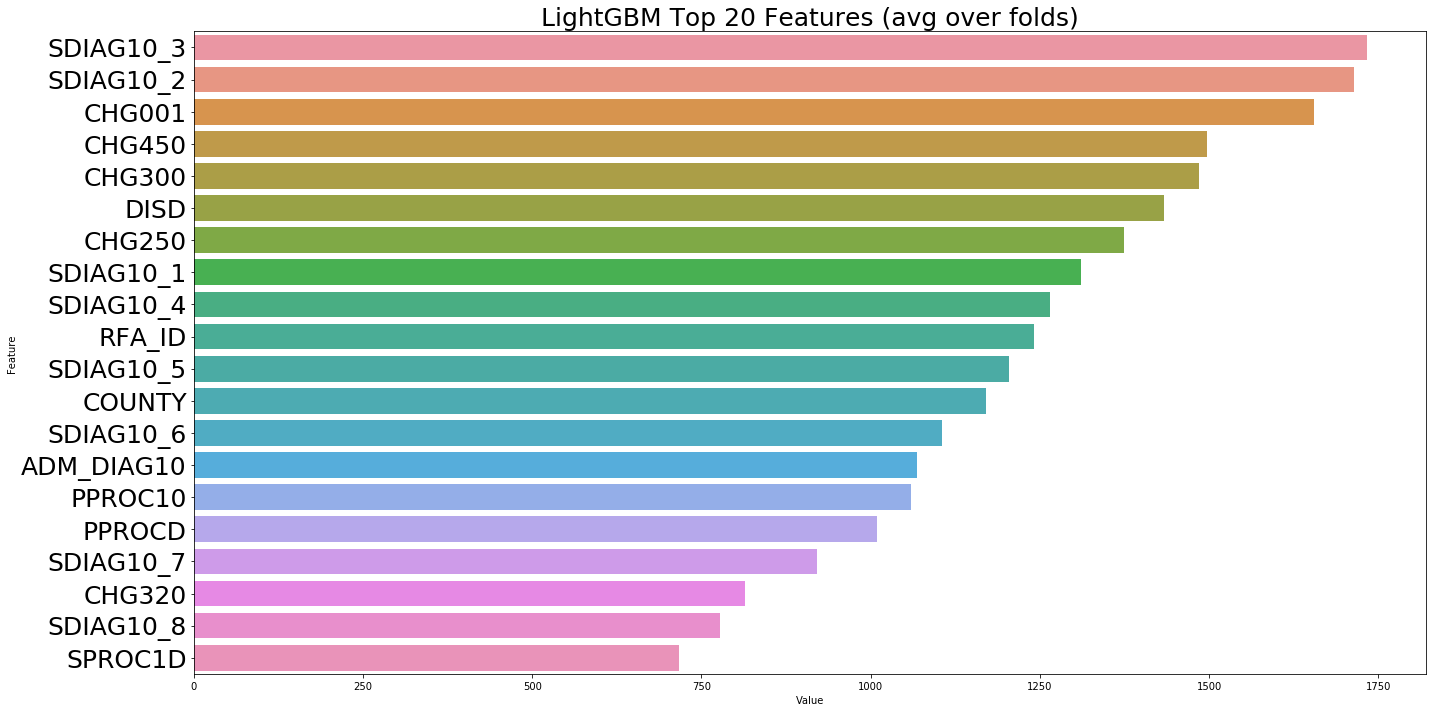

In [6]:
plt.figure(figsize=(20, 10))
b = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
b.set_yticklabels(ylabels, size=25)
plt.title('LightGBM Top 20 Features (avg over folds)', fontsize=25)
plt.tight_layout()
plt.show()

In [7]:
# Permutation importance
perm_valid = df_train.sample(50_000)
val_x = perm_valid[use_cols]
val_y = perm_valid[TARGET]

perm = PermutationImportance(model_lgb, random_state=42).fit(val_x, val_y)

In [8]:
eli5.show_weights(perm, feature_names = X_valid.columns.tolist(), top=None)

Weight,Feature
0.2411 ± 0.0071,ADM_DIAG10
0.1596 ± 0.0041,APDRGDSC
0.0623 ± 0.0032,CC_GRP_10
0.0570 ± 0.0026,PECODE10
0.0525 ± 0.0024,SDIAG10_1
0.0400 ± 0.0007,PPROC10
0.0353 ± 0.0019,CC_GRP_6
0.0254 ± 0.0006,CC_GRP_2
0.0220 ± 0.0013,CHG300
0.0195 ± 0.0010,CHG250
